# Gaze Estimation

In [24]:
#import pickle

#Basic
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Aiding conversions from string to list
import ast

#Randomize
import random

#Labelling classifiers
import time

#Support Vector Classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from joblib import dump, load
#from sklearn import svm, grid_search

## 1. Recording a video

Just record it. Falar de algumas precauções e cuidades. IDK

## 2. Converting the video in measurable data / Data treatment

### 2.1 Importing the text file

To do so, we created [datasetGenerating.py](https://github.com/antonioramiro/gaze-estimation/blob/master/datasetGenerating.py) which converts a video into an array of (~) 47 elements. yada yada yada

``demo da datasetGenerating`` .gif e o comando q se usa 

Then, to cluster every vector generated, each in an individual .txt file, we used [txtJoiner](https://github.com/antonioramiro/gaze-estimation/blob/master/txtJoiner.py), which outputs the following file yada yada. When said file is imported, the lines are read as strings, therefore it needs to be converted to a list of lists.

In [25]:
#opening the file
with open('dataset_2020-03-24.txt') as file:
    txt_file = [line.strip() for line in file]

dataset = []
#converting a list of strings to a list of lists
counter = 0
total_lines = len(txt_file)
while counter != total_lines:
    individual_line = ast.literal_eval(txt_file[counter])
    dataset += [individual_line]
    counter+=1

#### 2.1.1 Understanding the data

meter aqui imagem do boneco, com a legenda adequada ao nosso vetor. como por aquilo bonito? fica melhor explicado por escrito do que tudo discriminado.

``[x_nose, y_nose, x_right ear, y_right ear, x_left ear, y_left ear, x_right eye, y_right eye, x_left eye, y_left eye, x_right hand, y_right hand, x_left hand, y_left hand, ... contextual information - 32 positions ..., quadrant]``

### 2.2 Increasing sample size

inverter horizontalmente as cenas + termos o dobro dos dados. nota: a geradora do dataset cospe a resolução das imagens na sua penúltima linha

In [26]:
print('Initially, the dataset is composed by ' + str(len(dataset)) + ' elements.')

Initially, the dataset is composed by 11 elements.


In [27]:
resolution = (640,352) 
flipped_dataset = []

# Calculate the simetric quadrant, where the input is an int and the output is a list of 1 element.
# Given the numeration of quadrants (stated in 2.1.1), a simple addition/subtraction of 3 or 5 will yield
# the simetric quadrant

def flipped_quadrant(quadrant):
    if quadrant in [1,3,9,11]:
        flipped_quadrant = quadrant + 3 
    elif quadrant in [4,6,12,14]:
        flipped_quadrant = quadrant - 3 
    elif quadrant in [0,2,8,10]:
        flipped_quadrant = quadrant + 5
    elif quadrant in [5,7,13,15]:
        flipped_quadrant = quadrant - 5  
    return [flipped_quadrant]
    

for element in dataset:
    flipped_element = []
    for i in range(len(element) - 33):
        
        # Every even index (up to the 14th: indexes that correspond to coordinates of poseKeypoints) contains 
        # an X coordinate, from which can be obtained the simetric coordinate (by subtracting to the width
        # the original X), note that Y is irrelevant to horizontal simetry.
        
        if i%2 == 0 and element[i] != -1: #x
            flipped_element += [resolution[0] - element[i]]
                                            
        else: #y or x == -1
            flipped_element += [element[i]]       
        
    flipped_dataset += [flipped_element + element[14:-1] + flipped_quadrant(element[-1])]

dataset += flipped_dataset

In [28]:
print('Now, it has ' + str(len(dataset)) + ' elements.')

Now, it has 22 elements.


### 2.2.1 Leveling the data - corrigir numeracao

Now, we'll try to minimize the dataset bias by selecting the quadrant with the least amount of samples and a percentage in which the rest of the samples may differ. This way, we'll delete the excess samples from the other quadrants.  Due to XXXX, some quadrants tend to be more prevalent. So in order not to confuse :p the SVM, the values should be more homogenized  Falar um pouco

Firstly lets visualise the distributtion of data with the following function

In [12]:
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
%matplotlib inline

def heatmap (dataset):
    #in the quadrant_count list, each number corresponds to the number of samples where the object is in that
    #quadrant so quadrant_count[0] is the number of samples in the 0 quadrant
    quadrant_count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(dataset)):
        quad=dataset[i][-1]
        quadrant_count[quad]=quadrant_count[quad]+1
    data=[[quadrant_count[0],quadrant_count[1],quadrant_count[4],quadrant_count[5]],\
           [quadrant_count[2],quadrant_count[3],quadrant_count[6],quadrant_count[7]],\
           [quadrant_count[8],quadrant_count[9],quadrant_count[12],quadrant_count[13]],\
           [quadrant_count[10],quadrant_count[11],quadrant_count[14],quadrant_count[15]]]
    sns.heatmap(data, annot=True, fmt="d",linewidths=0.5,yticklabels=False,xticklabels=False,cbar=False)
    return quadrant_count

Prior to leveling, we have

[2, 2, 1, 3, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 2]

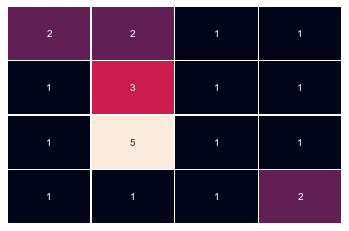

In [20]:
dataset=[[1,1,0],[2,2,0],[1,2,1],[1,2,1],[0,0,2],[1,3,3],[3,2,3],[1,2,3],[1,5,4],[5,5,5],[1,2,6],[1,2,7],[6,2,8],[1,3,9],[2,3,9],[3,3,9],[4,3,9],[5,3,9],[3,0,10],[1,3,11],[1,2,12],[3,3,13],[4,4,14],[5,3,15],[2,3,15]]
heatmap(dataset)

Now we shall define the levelling function

In [21]:
def levelling (dataset,percent):
    #percent indicates de percentage of samples we'll allow of difference 
    #between the smallest samples and all the rest
    quadrant_count=heatmap(dataset)
    a=quadrant_count[0]
    #we'll use the following cycle to find out what is the smallest number of samples we have in one quadrant
    #(doesn't matter which quadrant that is)
    for i in quadrant_count:
        if i<a:
            a=i
    max=(percent+1)*a
    excess=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(quadrant_count)):
        if quadrant_count[i]>max:
            excess[i]=quadrant_count[i]-max
        else:
            excess[i]=0
    while sum(excess)!=0:
        sample=random.randint(0,len(dataset))-1
        quad=dataset[sample][-1]
        if excess[quad]!=0:
            dataset=dataset[:sample]+dataset[sample+1:]
            excess[quad]=excess[quad]-1
    heatmap(dataset)
    return dataset

And apply it to our data, seeing a more homogeneyus ...

[[1, 1, 0],
 [2, 2, 0],
 [1, 2, 1],
 [1, 2, 1],
 [0, 0, 2],
 [3, 2, 3],
 [1, 2, 3],
 [1, 5, 4],
 [5, 5, 5],
 [1, 2, 6],
 [1, 2, 7],
 [6, 2, 8],
 [1, 3, 9],
 [2, 3, 9],
 [3, 0, 10],
 [1, 3, 11],
 [1, 2, 12],
 [3, 3, 13],
 [4, 4, 14],
 [5, 3, 15],
 [2, 3, 15]]

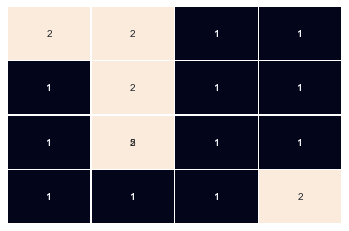

In [23]:
levelling(dataset,1)

#guardar o novo dataset em dataset, var global

### 2.3 Separating data for testing and for training

Now let's get the party going. Separate data

In [11]:
size = len(dataset)


In [12]:
total_frames = len(dataset)
testing_data = []
training_data = []

for i in range(int(0.2*total_frames)):
    element_to_transfer = random.choice(dataset)
    testing_data += [element_to_transfer]
    dataset.remove(element_to_transfer)

training_data = dataset
dataset = []


In [13]:
(len(testing_data),len(testing_data)/size),(len(training_data),len(training_data)/size)

((4, 0.18181818181818182), (18, 0.8181818181818182))

## 3. Training the models & Classifying

### 3.1 Creating a proper list of vectors

Este step is only done here in order to reduce the probability of messing up and disconecting each X vector from the correspondant Y

In [14]:
def eXifY(data):
    X, Y = [element[0:-1] for element in data], [element[-1] for element in data]
    return X, Y

In [15]:
len(eXifY(training_data)[0]) == len(eXifY(training_data)[1])

True

### 3.2 Training & Classifying

Como o obj. é comparar a qualidade das classificações consoante o tipo de contxt dado, vamos treinar 4 modelos e testá-los e ver as diferenças, assim ta pa treinar

In [19]:
def trainning(X,y):
    
    #tudo o que está ali abaixo, depois entrava aqui
    
    tipo = (exemplo) # exemplo mal feito para depois identificares no nome qual o tipo de dados
        if len(X) = 46 (tudo) #nao vi bem os nrs
        if len(X) = 10 (cabeca)
        if len(X) = 14 (cabeca e maos)
        if len(X) = 43 (cabeca e contexto)
    return 'classificador com data e tipo^ de dados no nome.joblib','info do classif,+ +tipo + n da amostra.txt' 


#Opening the traindata file with all the coordinates of the important points.
#The last number of each line is the number of the quadrant 
with open("traindata.txt") as file: #ATTENTION: this filename comes from elsewhere, change if needed
    linestrain = [line.strip() for line in file] #erases the empty spaces in each line from the txt file

    
def coordsandquadrvectors(linestxt)

#Initialization  
numberquad = [] 
Allthecoords = [] 
counter = 0

length = len(linestxt)

#This cicle separates, in each line corresponding to one image
#the coordinates to the Allthecoords vector and the quadrant number to the numberquad vector
while counter != length:
    omega = ast.literal_eval(linestxt[counter]) # ast.literal_eval raises an exception if the input isn't a valid Python datatype, so the code won't be executed if it's not
    Allthecoords += [omega[:10]]
    if omega[-1] == -1: #if the quadrant number is -1 (mistakenly) it is replaced by the quadrant 0
        numberquad +=[0]
    else:
        numberquad +=[omega[-1]]
    counter+=1

return Allthecoords, numberquad, length

CoordsTrain, quadTrain = coordsandquadrvectors(linestrain)
    
#This function below selects the best parameters that will there be used with the SVC
def svc_param_selection(X, y, nfolds):
    Cs = [1000,100] #parameter 1
    gammas = [1e-06] #parameter 2  
    param_grid = {'C': Cs, 'gamma' : gammas} #all in one grid
    grid_search2 = grid_search.GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search2.fit(X, y)
    grid_search2.best_params_
    return grid_search2.best_params_
    
best = svc_param_selection(CoordsTrain, quadTrain, 3) #3 means a 3-fold cross-validation

clf = SVC(C= best['C'],gamma=best['gamma']) #creating the model with the best parameters
clf.fit(CoordsTrain, quadTrain) #fitting the model to the data

now = datetime.datetime.now()
timestamp = str(now.strftime("%Y%m%d_%H-%M-%S")) #the current day and time to have to the classifier name 

classif_name = "classifier_"+timestamp+".joblib" 

dump(clf,classif_name, protocol=2) #creating the classifier file

SyntaxError: invalid syntax (<ipython-input-19-ad63199ebc2b>, line 7)

assim ta pa testar

In [ ]:
def testing(X,y,classif)

    meter considerações osbre a eficácia deste classificador no .txt criado anteriormente
    return conf matrixes e printar considerações
    mete o classif em variavel global, para depois o poder puxar sem ter de dizer o nome do ficheiro



#ATTENTION: the covariance matrices comments are TEMPORARY since we don't know if it's necessary (one method is implemented but not sure if it's the right one)

#Opening the testdata file with all the coordinates of the important points.
#The last number of each line is the number of the quadrant 
with open("testdata.txt") as file: #ATTENTION: this filename comes from elsewhere, change if needed
    linestest = [line.strip() for line in file]

coordsTest,quadTest, lengthtest = coordsandquadrvectors(linestest)  

#Predicting part: using the classifier to predict 
#(NOT USING THE FILE SAVED, IT ONLY RUNS IF THE CLASSIFIER WAS BUILT IN THE SAME SESSION)

#Extra Initialization 
Qpredicted= []
nmatching = 0 #number of right predictions
confMatrix = np.zeros((16,16))
i=0

while i != lengthtest:
Qpredicted+= [str(clf2.predict(np.array([coordsTest[i]]))).strip('['+']')] #predict
quadTest[i]= str(quadTest[i]) #converting to a string
    
confMatrix[int(Qpredicted[i])][int(quadTest[i])] += 1 
    
if Qpredicted[i] == quadTest[i]:
    nmatching+=1
    
i+=1

persucess = (float(nmatching)/float(lengthtest)) * 100  


print('The percentage of success was: ' + str(persucess)+ ' %')

#print(str(confMatrix))

#def sum1(input):
 #   sum = 0
  #  for row in range (len(input)):
   #     for col in range(len(input[0])):
    #        sum = sum + input[row][col]

#    return sum
#print(sum1(confMatrix))

#### 3.2.1 Using only the face keypoints

Since we're using only the keypoints of the face, we'll delete context info (short/long) and hands coordinates. As coords da cara são os 10 primeiros items 5*2 (x,y)

In [16]:
X, y = eXifY(training_data)
X = [i[:10] for i in X]

In [22]:
y

[7, 6, 13, 13, 6, 6, 6, 12, 6, 3, 2, 3, 3, 3, 3, 8, 9, 3]

Dizer coisas aqui sobre o que se vai passar

In [ ]:
trainning(X,y)

Now ... Dizer coisas aqui sobre o que se vai passar

In [32]:
X, y = eXifY(testing_data)
X = [i[:10] for i in X]

In [ ]:
testing(X,y)

#### 3.2.1 Using only keypoints (face + hands)

Since we're using only the keypoints, we'll delete context info (short/long). os 14 primeiros items 5*2 (x,y) da cara  + 2*2 (x,y) das mãos

In [ ]:
X, y = eXifY(training_data)
X = [i[:12] for i in X]

In [ ]:
X

In [ ]:
y

In [ ]:
trainning(X,y)

In [ ]:
X, y = eXifY(testing_data)
X = [i[:12] for i in X]

In [ ]:
testing(X,y)

#### 3.2.1 Using only the keypoints of the face and context data

Since we're using only the keypoints, we'll delete hands coordinates. #primeiros 10 + do 15 até ao 46

In [ ]:
X, y = eXifY(training_data)
X = [i[:10] + i[14:] for i in X]

In [ ]:
X

In [ ]:
y

In [ ]:
trainning(X,y)

In [ ]:
X, y = eXifY(testing_data)
X = [i[:10] + i[14:] for i in X]

In [ ]:
testing(X,y)

#### 3.2.1 Using they keypoints of the face, hands and context

Since we're using only the keypoints, we'll delete context info (short/long) and hands coordinates.

In [ ]:
X, y = eXifY(training_data)


In [ ]:
X

In [ ]:
y

In [ ]:
X, y = eXifY(testing_data)

In [ ]:
testing(X,y)

## 4. Comparing classifications

fazer conf. matrix bonita https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py